In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling.models import LogParabolaSpectralModel, Models, SkyModel
import numpy as np
import scipy as sc
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
import scipy.stats as st

First lets define some functions:

In [2]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

def Gauss(E, A, mu, sigma):
    return A * (np.exp(-1/2 * np.square((E - mu) / sigma)) / (sigma * np.sqrt(2*np.pi)))

def Gauss_int(A, mu, sigma, Em, Ep):
    return quad(Gauss, Em, Ep, args=(A, mu, sigma)) #maybie some mistake here because of log scale

Ler's read all needed files:

In [11]:
fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
EffaE= EffA['E [TeV]'].to_numpy()
Effa = EffA['Eff area (m^2)'].to_numpy()

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
Bkgpd = pd.DataFrame(fileBkg)
Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
BckgEdiff = BckgEmax - BckgEmin

BckgElogmean = []
for i in range(len(Bckg)):
    BckgElogmean.append(10**(np.mean([np.log10(BckgEmax[i]), np.log10(BckgEmin[i])])))


Ebinsmin = np.zeros(len(E))
Ebinsmax = np.zeros(len(E))

for i in range(1, len(E)):
    Ebinsmin[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i-1])]))
for i in range(len(E) - 1):
    Ebinsmax[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i+1])]))
    
Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
Ebinsmax[len(E)-1] = 10**(np.log10(Ebinsmax[len(E)-2])-(np.log10(Ebinsmax[len(E)-3])-np.log10(Ebinsmax[len(E)-2])))
Ebinsw = Ebinsmax - Ebinsmin

DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2
def log_interp1d(xx, yy):
    logx = np.log10(xx)
    logy = np.log10(yy)
    interp = interpolate.interp1d(logx, logy, fill_value='extrapolate', kind='slinear')
    log_interp = lambda zz: np.power(10.0, interp(np.log10(zz)))
    return log_interp

interpolation = log_interp1d(BckgElogmean,DifBckg)

newBckgrate = np.zeros([len(E[2:37]),2])
for i in range(len(E[2:37])):
    newBckgrate[i] = quad(interpolation, Ebinsmin[i+2], Ebinsmax[i+2])
newBckgrate = newBckgrate[:,0]

#“photon index  = 2.03  +/- 0.03 and normalization factor at 250 GeV    f0 = (8.70 +/- 0.17) * 10^-10 cm^-2  s^-1  TeV^-1.”
K =  8.70e-6#8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)

EffaA2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EffaE[9:51])):
        if EffaE[j+9] < E[i+2] and EffaE[j+10] > E[i+2]:
            m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
            n = Effa[j+9] - m * EffaE[j+9]
            EffaA2[i] = m * E[i+2] + n

fileAng = np.loadtxt('Angres.txt', skiprows = 11)
Angresall = pd.DataFrame(fileAng)
Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
AngresE= Angresall['E [TeV]'].to_numpy()
Angres = Angresall['Angular resolution (deg)'].to_numpy()

logAngres = np.log10(Angres)
logAngresE = np.log10(AngresE)
logE = np.log10(E)


logAngres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(AngresE[1:-1])):
        if logAngresE[j+1] < logE[i+2] and logAngresE[j+2] > logE[i+2]:
            m = (logAngres[j+2]-logAngres[j+1])/(logAngresE[j+2]-logAngresE[j+1])
            n = logAngres[j+1] - m * logAngresE[j+1]
            logAngres2[i] = m * logE[i+2] + n
Angres2 = 10**logAngres2

def degtorad(ang):
    return ang * np.pi / 180


time = 42480 #42480 #180000#s
skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(degtorad(Angres2)))#deg^2

bckgmu = newBckgrate * time * skyang

fileEres = np.loadtxt('Eres.txt', skiprows = 8)
Eresall = pd.DataFrame(fileEres)
Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
EresE = Eresall['E [TeV]'].to_numpy()
Eres = Eresall['Energy resolution (deg)'].to_numpy()

logEres = np.log10(Eres)
logEresE = np.log10(EresE)
logE = np.log10(E)


logEres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EresE[0:-1])):
        if logEresE[j] < logE[i+3] and logEresE[j+1] > logE[i+3]:
            m = (logEres[j+1]-logEres[j])/(logEresE[j+1]-logEresE[j])
            n = logEres[j] - m * logEresE[j]
            logEres2[i] = m * logE[i+3] + n
Eres2 = 10**logEres2
Eres3 = Eres2 * E[2:37]


logEbins = np.zeros(len(E[2:37])+1)
for i in range(len(E[2:37])+1):
    if i == 0:
        logEbins[i] = logE[2] - ((logE[3]-logE[2])/2)
    elif i == (len(E[2:37])):
        logEbins[i] = logE[2:37][i-1] + ((logE[2:37][i-1]-logE[2:37][i-2])/2)
    else:
        logEbins[i] = (logE[2:37][i] + logE[2:37][i-1]) / 2

Ebins = 10 ** logEbins

mu_vec = dNdEa[2:37] * EffaA2 * Ebinsw[2:37] * time

mu_vec_reco = np.zeros(len(mu_vec))
mu_vec_i = np.zeros(len(mu_vec))

for i in range(len(mu_vec)):
    for j in range(len(mu_vec)):
        A = mu_vec[i]
        B = bckgmu[i]
        Em = Ebins[j]
        Ep = Ebins[j+1]
        sigma = Eres3[i]
        mu = E[2:37][i]

        mu_vec_i[j] = Gauss_int(A, mu, sigma, Em, Ep)[0]
    mu_vec_reco = mu_vec_reco + mu_vec_i

In [12]:
def concaveLP(xdata, params):
    phi0 = params[0]
    alpha = params[1]
    beta = params[2]
    #Enorm = 1TeV #if it is 1 TeV no need ot include it (if it is different, need to add it to te LP function)
    LP = phi0 * (xdata) ** (alpha - beta * beta * np.log(xdata))
    return LP

def LSQ_LP(params):
    return np.sum((ydata - concaveLP(xdata, params)) ** 2 / ydata_u ** 2)

def LP_fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ_LP.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ_LP, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    m.tol = 1e-20

    m.migrad()
    # print(m.values)

    m.hesse()
    # print(m.errors)

    return m

In [13]:
def PWL(xdata, params):
    phi = params[0]
    gamma = params [1]
    PLW = phi * xdata ** (-gamma)
    return PLW

def LSQ_PWL(params):
    return np.sum((ydata - PWL(xdata, params)) ** 2 / ydata_u ** 2)

def PWL_fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ_PWL.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ_PWL, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    m.tol = 1e-20

    m.migrad()
    # print(m.values)

    m.hesse()
    # print(m.errors)

    return m

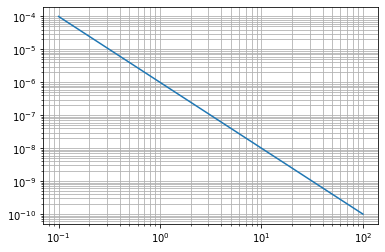

In [14]:
xdata = np.logspace(-1, 2, 300)
ydata = PWL(xdata, [1e-6, 2.])
plt.plot(xdata, ydata)
plt.grid(which="both")
plt.xscale('log')
plt.yscale('log')

In [29]:
niter = 1000 #number of iterations (1000 iterations take ~19 min)
chisqs_iter = []
alphas_iter = []
initial_guess_pos = 1.5
step = 0.05
last_bin = 2.
first_bin = 0.

for j in range(niter):
    my_generator = np.random.default_rng(j)
    Simbckg1 = my_generator.poisson(bckgmu)
    # Simbckg1 = Simbckg1.astype(float)
    # for i in range(len(Simbckg1)):
    #     if Simbckg1[i] == 0:
    #         Simbckg1[i] = bckgmu[i]
    Simbckg1_u = np.sqrt(Simbckg1)
    Simbckg5 = my_generator.poisson(5*bckgmu)/5
    # Simbckg5 = Simbckg5.astype(float)
    # for i in range(len(Simbckg5)):
    #     if Simbckg5[i] == 0:
    #         Simbckg5[i] = bckgmu[i]
    Simbckg5_u = np.sqrt(Simbckg5)

    N = my_generator.poisson(mu_vec_reco)

    for i in range(len(N)): #this is used to avoid crashing when dividing by 0.
        if N[i] == 0:
            N[i] = 1
    N_u = np.sqrt(N)

    NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
    NpB_u = N_u + Simbckg1_u - Simbckg5_u

    dNdE_b = NpB[1:] / EffaA2[1:35] / Ebinsw[3:37] / time  #not strictly correct after energy migration
    dNdE_b_u = NpB_u[1:] / EffaA2[1:35] / Ebinsw[3:37] / time

    SED = np.square(E[3:37]) * dNdE_b
    SED_u = np.square(E[3:37]) * dNdE_b_u

    chisqs = []
    # alphas = np.arange(0,2.05,0.05) #if you want to change the alpha values
    alphas1 = np.arange(initial_guess_pos + step, last_bin + step, step)
    alphas2 = np.arange(initial_guess_pos, first_bin - step, -step)
    alphas = np.append(alphas1, alphas2)

    alpha = initial_guess_pos
    dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
    dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
    SED2 = np.square(E[7:37]) * dNdE2
    SED_u2 = np.square(E[7:37]) * dNdE2_u
    ydata = SED2
    xdata = E[7:37]
    ydata_u = SED_u2
    initial_guess = np.array([5e-7, 2.]) #phi_0, lam1, deltas (len(deltas)=knots))
    things = PWL_fit(initial_guess=initial_guess)


    initial_guess_mat = np.zeros((len(alphas)+1, len(initial_guess)))
    initial_guess_mat[0] = things.values #phi_0, lam1, deltas (len(deltas)=knots))

    for i in range(len(alphas)):
        alpha = alphas[i]
        #print("alpha = ", alpha)
        dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
        dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
        SED2 = np.square(E[7:37]) * dNdE2
        SED_u2 = np.square(E[7:37]) * dNdE2_u
        ydata = SED2
        xdata = E[7:37]
        ydata_u = SED_u2

        initial_guess = initial_guess_mat[i] #phi_0, lam1, deltas (len(deltas)=knots))
        # if alpha == initial_guess_pos:
        #     initial_guess = initial_guess_mat [0]
        things = PWL_fit(initial_guess=initial_guess)
        if i < (len(alphas)):
            initial_guess_mat[i+1] = things.values
        chi2 = chisq(SED2, PWL(E[7:37],things.values), SED_u2)
        chisqs.append(chi2)
        # if alpha == 1.5 and j == 1:# or alpha == 0.15 or alpha == 0.9 or alpha == 1.:
        #     print(chi2)
        #     plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
        #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
        #     plt.xscale('log')
        #     plt.yscale('log')
        #     plt.xlabel(r"$E$ ($TeV$)")
        #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
        #     plt.legend()
        #     plt.show() 

    alphas_iter.append(alphas)
    chisqs_iter.append(chisqs)
    print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

 iteration 1 of 1000 finished 
[ 816 1056 1579 1938 2205 2404 2399 2518 2499 2297 2245 1943 1721 1526
 1229 1039  842  669  545  344  244  187  137  118   85   64   43   36
   32   22   25   17    8    5    6]
 iteration 2 of 1000 finished 
 iteration 3 of 1000 finished 
 iteration 4 of 1000 finished 
 iteration 5 of 1000 finished 
 iteration 6 of 1000 finished 
 iteration 7 of 1000 finished 
 iteration 8 of 1000 finished 
 iteration 9 of 1000 finished 
 iteration 10 of 1000 finished 
 iteration 11 of 1000 finished 
 iteration 12 of 1000 finished 
 iteration 13 of 1000 finished 
 iteration 14 of 1000 finished 
 iteration 15 of 1000 finished 
 iteration 16 of 1000 finished 
 iteration 17 of 1000 finished 
 iteration 18 of 1000 finished 
 iteration 19 of 1000 finished 
 iteration 20 of 1000 finished 
 iteration 21 of 1000 finished 
 iteration 22 of 1000 finished 
 iteration 23 of 1000 finished 
 iteration 24 of 1000 finished 
 iteration 25 of 1000 finished 
 iteration 26 of 1000 finished

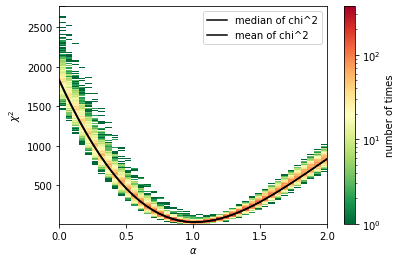

In [16]:
chisqs_iter = np.array(chisqs_iter)
alphas_iter = np.array(alphas_iter)
alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.concatenate(chisqs_iter)
order = np.argsort(alphas_iter[0])


fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.median(chisqs_iter,0), order, axis=0), color = "black", label="median of chi^2")
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean of chi^2")
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),300], norm = colors.LogNorm(), cmap = "RdYlGn_r", label="histogram of chi^2 values")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
ax.legend()
# ax.set_ylim(0,200)
# ax.set_xlim(0.5,1.15)
fig.colorbar(h[3], ax=ax, label="number of times")

In [17]:
interpx = np.arange(0., 1.5, 0.01)
alphas_reord = np.take_along_axis(alphas_iter[0], order, axis=0)
chisqs_repord = np.take_along_axis(np.median(chisqs_iter,0), order, axis=0)
f1 = interpolate.interp1d(alphas_reord, chisqs_repord, kind='linear')
chis_new = f1(interpx)
interpx[np.argmin(chis_new)]

1.0

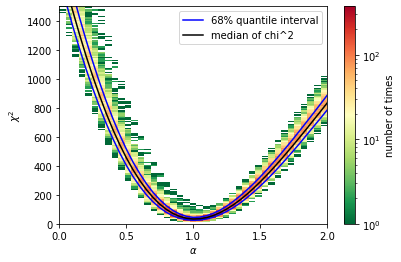

In [18]:
quantiles1 = np.zeros(len(chisqs_iter))
quantiles2 = np.zeros(len(chisqs_iter))
for i in range(len(chisqs_iter[1])):
    quantiles1[i] = np.quantile(chisqs_iter[:,i], 0.84135)
    quantiles2[i] = np.quantile(chisqs_iter[:,i], 0.15865)



fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(quantiles1, order, axis=0), color = "blue", label="68% quantile interval")
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(quantiles2, order, axis=0), color = "blue")
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.median(chisqs_iter,0), order, axis=0), color = "black", label="median of chi^2")
h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),300], norm = colors.LogNorm(), cmap = "RdYlGn_r", label="histogram of chi^2 values")
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
# ax.fill_between(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(quantiles1, order, axis=0), np.take_along_axis(quantiles2, order, axis=0), alpha=0.15, label="68% confidence interval")
ax.legend()
ax.set_ylim(0,1500)
# ax.set_xlim(0.5,1.15)
fig.colorbar(h[3], ax=ax, label="number of times")

In [19]:
alphas_iter[0][np.argmin(np.median(chisqs_iter,0))]

0.9999999999999996

In [20]:
sigma_1 = []
sigma_2 = []
sigma_3 = []
s1 = 0
s2 = 0
s3 = 0
for i in range(len(alphas_iter)):
    sigma_1_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
    sigma_2_0 = np.where(chisqs_iter[i] <= 4 + np.min(chisqs_iter[i]))
    sigma_3_0 = np.where(chisqs_iter[i] <= 9 + np.min(chisqs_iter[i]))
    sigma_1.append(sigma_1_0)
    sigma_2.append(sigma_2_0)
    sigma_3.append(sigma_3_0)
    if 20 in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
        s1 += 1
    if 20 in sigma_2_0[0]:
        s2 += 1
    if 20 in sigma_3_0[0]:
        s3 += 1
# print(sigma_1)
# print(sigma_2)
# print(sigma_3)
print(s1)
print(s2)
print(s3)

662
896
980


In [13]:
print(alphas_iter[0][20])

0.9999999999999996


In [23]:
print(np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0))

[1835.96336936 1655.9581613  1484.98828913 1323.29453694 1171.08093855
 1028.51303388  895.7164352   772.77572411  659.73369631  556.59096632
  463.30594023  379.79516033  305.93402126  241.55785418  186.46337179
  140.41046473  103.1243371    74.29796713   53.59487629   40.65218823
   35.08395562   36.48472891   44.4333361    58.49683559   78.23459615
  103.20244869  132.95684437  167.05894438  205.07855848  246.59784513
  291.21468607  338.5456537   388.22850192  439.9241286   493.3179798
  548.12089104  604.06938504  660.92546822  718.4759861   776.53161031
  834.92553639]
